# Demonstration of `photutils.psf` with an image-based PSF Model

In [1]:
import os
import sys

import numpy as np

from astropy import units as u
from astropy.table import Table
from astropy.io import fits
from astropy import wcs

%matplotlib inline
from matplotlib import style, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
import photutils
from photutils import psf
from astropy.modeling import models

photutils.__version__

'0.5'

# Build a simulated image with a funky elliptical Moffat-like PSF (but no noise)

<CompoundModel5(offset_0=0., offset_1=0., angle_2=-20., factor_4=1.5, amplitude_5=1., x_0_5=0., y_0_5=0., gamma_5=6., alpha_5=4.76)>

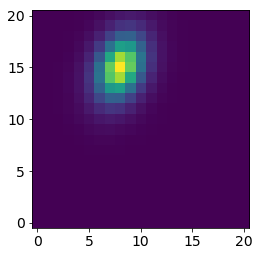

In [3]:
psfmodel = ((models.Shift(-5) & models.Shift(2)) | 
            models.Rotation2D(-20) | 
            (models.Identity(1) & models.Scale(1.5)) | 
            models.Moffat2D(1, 0,0, 6, 4.76))

psfmodel.bounding_box = ((-10, 10), (-10, 10))
psfim = psfmodel.render().T
plt.imshow(psfim)
psfmodel.offset_0 = psfmodel.offset_1 = 0
psfimcen = psfmodel.render()
del psfmodel.bounding_box

psfmodel

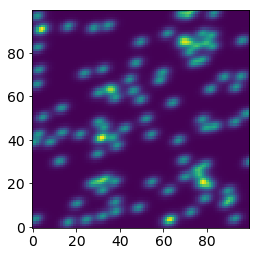

In [4]:
im = np.zeros((100, 100))

amps = np.random.randn(100)**2
xs = im.shape[0] * np.random.rand(amps.size)
ys = im.shape[1] * np.random.rand(amps.size)

for x, y, amp in zip(xs, ys, amps):
    psfmodel.amplitude_3 = amp
    psfmodel.offset_1 = -x
    psfmodel.offset_0 = -y
    
    psfmodel.render(im)
plt.imshow(im)

## Now we use  `FittableImageModel` on a *rendered* version of the PSF model with no pixel subsampling

<Figure size 432x288 with 0 Axes>

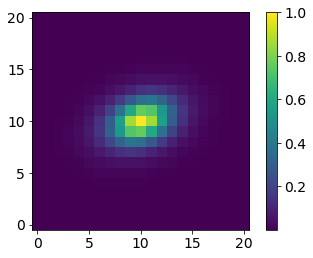

<Figure size 432x288 with 0 Axes>

In [5]:
plt.imshow(psfimcen)
plt.colorbar()
psf_im_model = psf.FittableImageModel(psfimcen, normalize=1)

plt.figure()

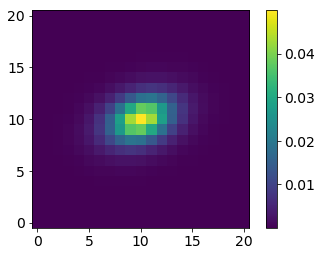

In [6]:
psf_im_model.bounding_box = ((-10, 10), (-10, 10))
psfrendered = psf_im_model.render()
del psf_im_model.bounding_box
plt.imshow(psfrendered)
plt.colorbar()

## Now lets try doing photometry

First we need to find stars.  We'll use the DAOPhot algorithm (which at its core is the same as most other PSF photometry tools).

First we estimate the variance in the image to give us some guess as to what might be a good threshold for star-finding.

In [7]:
from astropy.stats import SigmaClip
bkg_var = photutils.background.BiweightScaleBackgroundRMS(
            sigma_clip=SigmaClip(3))(im)
bkg_var

/Users/juan/anaconda3/envs/astropy-workshop/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.07067539336099146

Then we create a `DAOStarFinder` object and run that on the image

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,16.200463292083054,2.2063500260116498,0.5348790393817127,0.22545215389083975,-0.4998379107200721,49,0.0,0.9923432512790333,39.466688729333825,-3.990576726116487
2,24.59333446094617,3.2670333729211354,0.5480628131163696,0.35216632925775065,-0.5838145675911564,49,0.0,0.9606653026167798,35.00829709052758,-3.860427464703635
3,62.618595603936384,3.3555005224692263,0.5216342232879514,0.23246960335932326,-0.3720099914010398,49,0.0,1.8302785656173848,70.76876897132809,-4.624604102705062
4,1.4962418029078746,3.654972074727574,0.5417452364400607,0.09053945812268162,0.06373069679578516,49,0.0,0.9537071353745751,41.00856097234348,-4.032186324417466
5,92.62709997931964,3.878863304469758,0.5462644879683902,0.42236992028836445,-0.42761064367799373,49,0.0,0.977547294962367,37.63972144941315,-3.9391160019896403
6,31.96255532678487,5.050377392432794,0.5640558134722755,0.2161342239808633,-0.6894644793294447,49,0.0,1.032861551119772,35.78009961691362,-3.8841038634274394
7,37.635691506354135,7.486558833084011,0.6001142950957729,0.17894753608461184,-0.22331864566461368,49,0.0,1.0413845336981251,30.99964376984972,-3.7283917579987897
8,72.40604322167269,6.805888051169244,0.5417928644241136,0.14149777208715553,-0.4521241719453481,49,0.0,0.971003954930103,36.9831902653517,-3.9200109295022676
9,48.38225794944014,8.872722270624772,0.5434676764039954,0.2586314057363608,-0.45118932031652903,49,0.0,0.974982002888483,37.536907209804,-3.936146216994027


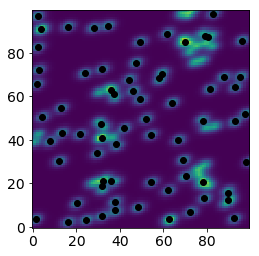

In [8]:
star_finder = photutils.findstars.DAOStarFinder(threshold=bkg_var/2, 
                                                fwhm=5)
found_stars = star_finder(im)

plt.imshow(im)
plt.scatter(found_stars['xcentroid'], found_stars['ycentroid'], color='k')

found_stars

And then we create the object to do the photometry, and run it on the table of stars we found.

id,x_0,y_0,sharpness,roundness1,roundness2,npix,sky,peak,flux_0,mag,group_id,y_fit,flux_fit,x_fit,flux_unc,x_0_unc,y_0_unc
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
1,16.200463292083054,2.2063500260116498,0.5348790393817127,0.22545215389083975,-0.4998379107200721,49,0.0,0.9923432512790333,39.466688729333825,-3.990576726116487,1,2.204698838299852,20.037794825913814,16.170557080635035,0.0,0.0,0.0
2,24.59333446094617,3.2670333729211354,0.5480628131163696,0.35216632925775065,-0.5838145675911564,49,0.0,0.9606653026167798,35.00829709052758,-3.860427464703635,1,3.3175242811140113,20.049817376269434,24.555248130970142,0.0,0.0,0.0
6,31.96255532678487,5.050377392432794,0.5640558134722755,0.2161342239808633,-0.6894644793294447,49,0.0,1.032861551119772,35.78009961691362,-3.8841038634274394,1,4.943620200953428,20.03322051145556,31.792313105878513,0.0,0.0,0.0
7,37.635691506354135,7.486558833084011,0.6001142950957729,0.17894753608461184,-0.22331864566461368,49,0.0,1.0413845336981251,30.99964376984972,-3.7283917579987897,1,7.130122848667945,20.07773969582342,38.01816759866194,0.0,0.0,0.0
10,20.177234543484886,10.767567552316331,0.5435594922087481,0.26865615286873185,-0.39662432209946963,49,0.0,0.9822030321095055,37.98465752624969,-3.9490205377807013,1,10.785178927231684,20.048862488258067,20.142857002445933,0.0,0.0,0.0
11,37.84309493183278,11.13704627221187,0.5733032078692929,0.38423962745080376,-0.03975906482423406,49,0.0,0.9733156781545539,31.52146161191573,-3.746515867481033,1,11.587508600697662,20.062138535687627,37.7252440723988,0.0,0.0,0.0
14,31.571489773688636,18.75070570921078,0.5287671378596853,0.10896342902735624,0.31632054801628906,49,0.0,0.8466757197407555,24.074509124883257,-3.453893601741909,1,16.92184951873519,20.437281618267466,31.65718041247329,0.0,0.0,0.0
18,35.87125501763039,21.128143469260714,0.5783369300748097,-0.374269608226192,-0.9709772977879383,49,0.0,1.0455290931254446,31.361710373854493,-3.740999349449961,1,21.089595615576663,21.427878716663436,37.3136651919611,0.0,0.0,0.0
20,32.157771396704426,21.195716692033947,0.5143622240837729,0.6484019893040791,-0.9526463667886005,49,0.0,1.5240120805403368,42.07584417069801,-4.060082095042004,1,21.485007372828374,36.59775642895253,31.717308477295443,0.0,0.0,0.0


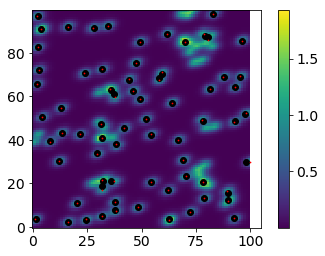

In [9]:
ph = psf.BasicPSFPhotometry(psf.DAOGroup(10), None, psf_im_model, 
                            (5, 5), aperture_radius=10)

if 'xcentroid' in found_stars.colnames:
    # there's an if here simply to make sure you can run this cell
    # multiple times without re-running the star finder
    found_stars['xcentroid'].name = 'x_0'
    found_stars['ycentroid'].name = 'y_0'
    found_stars['flux'].name = 'flux_0'
    
res = ph.do_photometry(im, found_stars)


plt.imshow(im)
plt.colorbar()
plt.scatter(res['x_0'], res['y_0'], color='k')
plt.scatter(res['x_fit'], res['y_fit'], color='r', s=3, lw=0)

res

And now we try making a residual image to see how well it did

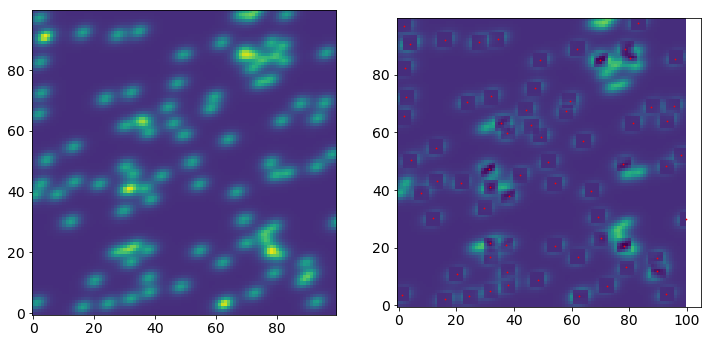

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

vmin, vmax = -.3, 2.

ax1.imshow(im, vmin=vmin, vmax=vmax)
ax2.imshow(ph.get_residual_image(), vmin=vmin, vmax=vmax)
ax2.scatter(res['x_fit'], res['y_fit'], color='r', s=3, lw=0)

Well that looks OK except that it looks ugly because our psf model that we fit was a bit small.  So lets try subtracting the *actual* model

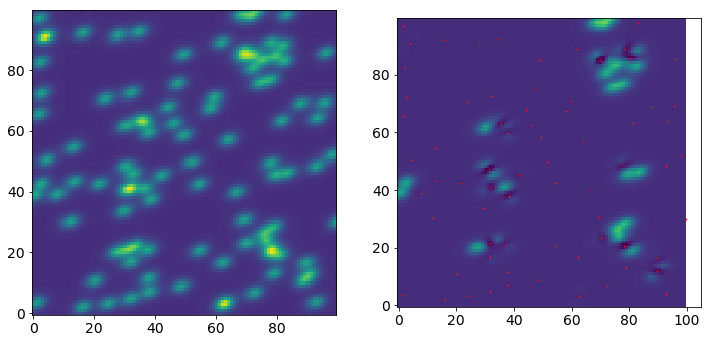

In [11]:
subtracted_image = psf.subtract_psf(im, psf_im_model, res)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

vmin, vmax = -.3, 2.

ax1.imshow(im, vmin=vmin, vmax=vmax)
ax2.imshow(subtracted_image, vmin=vmin, vmax=vmax)
ax2.scatter(res['x_fit'], res['y_fit'], color='r', s=3, lw=0)

# Simulated NIRCam data 

Now lets try something like the above, but with simulated NIRCam data, using an oversampled PSF.  

In principal this is one of two modes one might take with real JWST data.  For many cases using a provided PSF (or generated from `webbpsf`) will be sufficient.  But `photutils` will also support high-level tools to build "empirical" PSF's, e.g. directly built from the image.

You will need to download the simulated NIRCam image:

https://stsci.box.com/s/z2sbv2vuqbtsj75fnjdnalnsrvrdcvgt
(the downloaded file should be called `simulated_nircam_1.fits`)

and PSF image:

https://stsci.box.com/s/5kxh7vsvctc5u10ovvdeyv8n6w5tcds0
(the downloaded file should be called `simulated_nircam_psf_1.fits`)

Place both of these files in the same directory that you ran this notebook.

In [12]:
im1fn = 'simulated_nircam_1.fits'
psf1fn = im1fn.replace('_1.fits','_psf_1.fits')

In [13]:
im1f = fits.open(im1fn)
im1 = im1f[1].data
im1h = im1f[1].header
im1wcs = wcs.WCS(im1h)

psf1f = fits.open(psf1fn)
psf1 = psf1f[0].data
psf1h = psf1f[0].header
psf1wcs = wcs.WCS(psf1h)

FileNotFoundError: [Errno 2] No such file or directory: 'simulated_nircam_1.fits'

In [ ]:
# this is a quick-and-easy way to re-scale an image, using the 
# astropy.visualization package
from astropy.visualization import LogStretch, PercentileInterval

viz = LogStretch() + PercentileInterval(99)

In [ ]:
plt.imshow(viz(im1))

OK, lets histogram it so we can see roughly where the threshold should be

In [ ]:
plt.hist(im1.ravel(), bins=100, histtype='step', range=(-10, 200), log=True)
None

In [ ]:
dsf = photutils.DAOStarFinder(100, 5)
found_stars = dsf(im1)
found_stars['xcentroid'].name = 'x_0'
found_stars['ycentroid'].name = 'y_0'
found_stars['flux'].name = 'flux_0'
found_stars

In [ ]:
plt.imshow(viz(im1))
plt.scatter(found_stars['x_0'], found_stars['y_0'], lw=0, s=3, c='k')
plt.xlim(500, 1500)
plt.ylim(500, 1500)

The next cell is not critical, but if you have `imexam` installed you can use it to view the found stars in ds9.

In [ ]:
import imexam

imex = imexam.connect()
imex.load_fits(im1fn)
tomark = [(row['x_0'],row['y_0'],i) for i, row in enumerate(found_stars)]
imex.mark_region_from_array(tomark)

Now we build the actual PSF model using the file that the PSF is given in. It is using external knowledge that the PSF is 5x oversampled. The simple oversampling below only works as-is because both are square, but that's true here.

In [ ]:
# note that this is *not* the same pixel scale as the image above
plt.imshow(viz(psf1))

psfmodel = psf.FittableImageModel(psf1, oversampling=5)

Lets now zoom in on the image somewhere and see how the model looks compared to the actual image scale

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(viz(im1))
ax1.set_xlim(1080, 1131)
ax1.set_ylim(1100, 1151)
ax1.set_title('Simulated image')

xg, yg = np.mgrid[-25:25, -25:25]
ax2.imshow(viz(psfmodel(xg, yg)))
ax2.set_title('PSF')

Now we build a PSF photometry runner that is auto-configured to work basically the same as DAOPHOT.  All of the steps in photometry are customizable if you like, but for now we'll just use this because it's a familiar code to many people. 

In [ ]:
psfphot = psf.DAOPhotPSFPhotometry(crit_separation=5, 
                                   threshold=100, fwhm=5, 
                                   psf_model=psfmodel, fitshape=(9,9),
                                   niters=1, aperture_radius=5)
results = psfphot(im1, found_stars[:100])

Now lets inspect the residual image as a whole, and zoomed in on a few particular stars.

In [ ]:
res_im1 = psfphot.get_residual_image()
plt.imshow(viz(res_im1))
results

In [ ]:
# these *should* be one by itself and one near the core.  But you might 
# have to change the (10, 500) to something else depending on what you
# want to inspect
for i in (10, 50): 

    resulti = results[i]
    window_rad = 20

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.imshow(viz(im1))
    ax1.set_xlim(resulti['x_fit']-window_rad, resulti['x_fit']+window_rad)
    ax1.set_ylim(resulti['y_fit']-window_rad, resulti['y_fit']+window_rad)
    ax1.scatter([resulti['x_0']], [resulti['y_0']], color='r',s=7)
    ax1.scatter([resulti['x_fit']], [resulti['y_fit']], color='w',s=7)
    ax1.set_title('Original image (star #{})'.format(i))

    ax2.imshow(viz(res_im1))
    ax2.set_xlim(resulti['x_fit']-window_rad, resulti['x_fit']+window_rad)
    ax2.set_ylim(resulti['y_fit']-window_rad, resulti['y_fit']+window_rad)
    ax2.scatter([resulti['x_0']], [resulti['y_0']], color='r',s=7)
    ax2.scatter([resulti['x_fit']], [resulti['y_fit']], color='w',s=7)
    ax2.set_title('Subtracted image (star #{})'.format(i))

OK, looks like at least some of them worked great, but in the crowded areas more iterations/tweaks to the input parameters are needed.  See if you can tweak the parameters to make it better!

For this simulated data set we only have one band, so there's not much output "science" to show... But below you see how to get out magnitudes, 

In [ ]:
# this does not yet exist... but the plan is that it will at launch!
#jwst_calibrated_mags(results['flux_fit'], im1h)

# it would do something like this:

# this zero-point is just a made-up number right now, 
# but it's something the instrument team will provide
inst_mag = -2.5*np.log10(results['flux_fit'])
zero_point = 31.2  
results['cal_mag'] = zero_point + inst_mag

# if you scroll to the right you'll see the new column
results

## Exercises

As you can see, particularly for brighter stars, the above procedure doesn't do well, primarily because the star finder doesn't find them efficiently along with the faint ones.  Try manually editing the `found_stars` table and by-hand insert a few bright stars.  See if you can get them to subtract well. 

Now try playing around with the various options and see if you can do better *automatically*.